# ML IN FINANCE, PROJECT 1

In [26]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

# Data handling and numerical operations
import pandas as pd
import numpy as np
import itertools

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy import stats
from scipy.stats import probplot, spearmanr
from scipy.stats import kurtosis, skew


# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD

# Statsmodels for OLS regression
import statsmodels.api as sm


## Task Nr.1

### A

In [27]:
# Load the dataset
housing = pd.read_csv('housing.csv')

# Display the first few rows of the dataset to verify
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### B

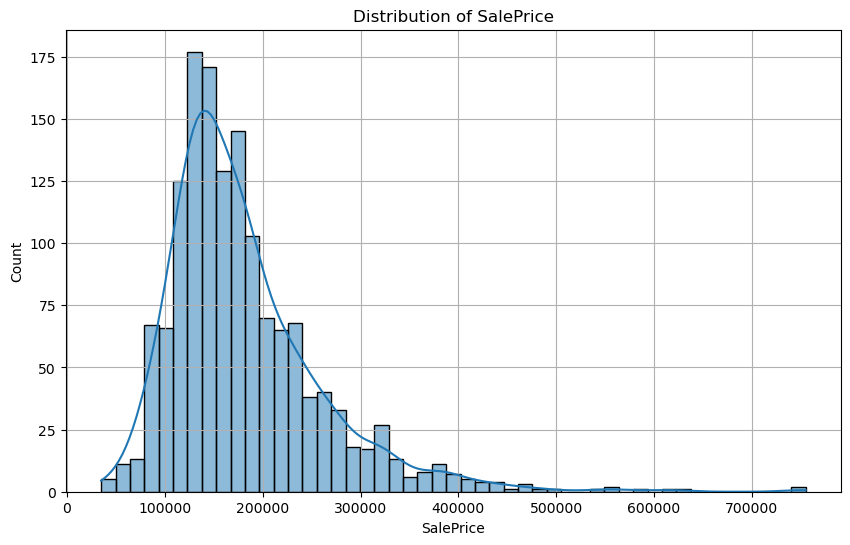

Kurtosis of SalePrice: 9.509812011089439 (ideal value = 3)
Skewness of SalePrice: 1.880940746034036 (ideal value = 0)


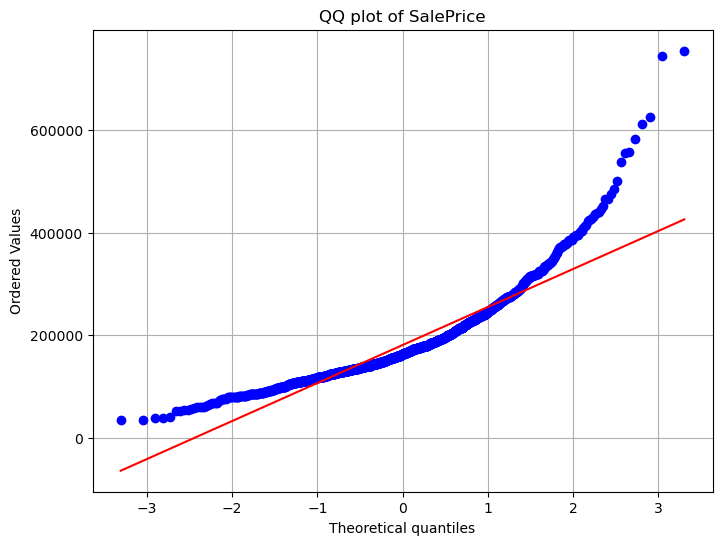

In [28]:
# Check the distribution of the target variable 'SalePrice'
plt.figure(figsize=(10, 6))
sns.histplot(housing['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.grid(True)
plt.show()

# Kurtosis and Skewness of SalePrice
saleprice_kurtosis = kurtosis(housing['SalePrice'], fisher=False)
saleprice_skewness = skew(housing['SalePrice'])

print(f"Kurtosis of SalePrice: {saleprice_kurtosis} (ideal value = 3)")
print(f"Skewness of SalePrice: {saleprice_skewness} (ideal value = 0)")

# Use a QQ plot to assess normality
plt.figure(figsize=(8, 6))
probplot(housing['SalePrice'], dist="norm", plot=plt)
plt.title('QQ plot of SalePrice')
plt.grid(True)
plt.show()

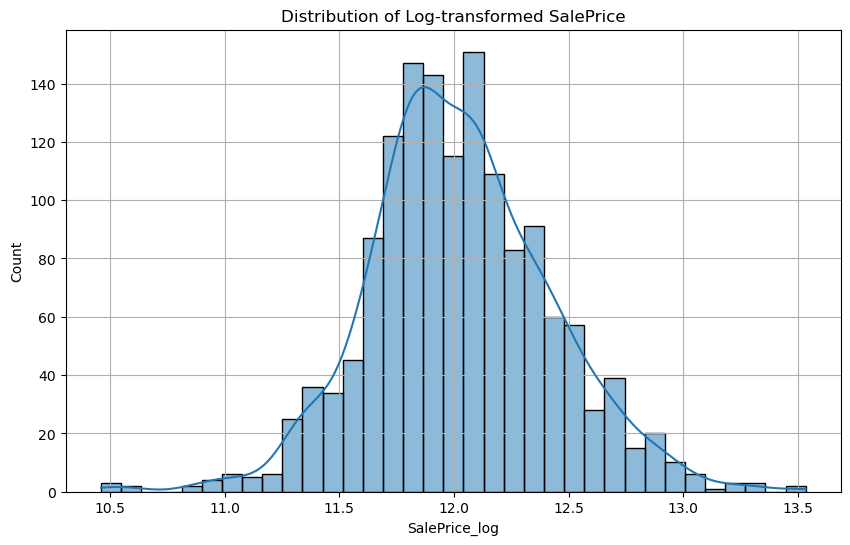

Kurtosis of Log-transformed SalePrice: 3.8026555069117713 (ideal value = 3)
Skewness of Log-transformed SalePrice: 0.1212103673013655 (ideal value = 0)


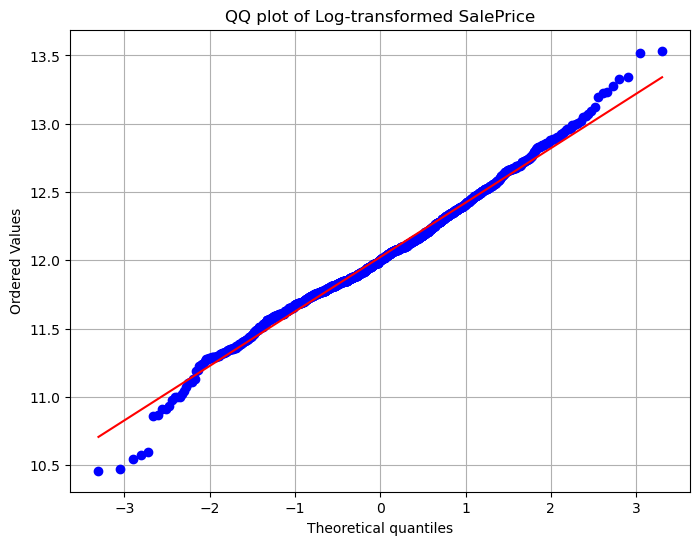

In [29]:
# Log transform the target variable if not normally distributed
housing['SalePrice_log'] = np.log(housing['SalePrice'])

# Check the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(housing['SalePrice_log'], kde=True)
plt.title('Distribution of Log-transformed SalePrice')
plt.grid(True)
plt.show()

# Kurtosis and Skewness of the transformed SalePrice
log_saleprice_kurtosis = kurtosis(housing['SalePrice_log'], fisher=False)
log_saleprice_skewness = skew(housing['SalePrice_log'])

print(f"Kurtosis of Log-transformed SalePrice: {log_saleprice_kurtosis} (ideal value = 3)")
print(f"Skewness of Log-transformed SalePrice: {log_saleprice_skewness} (ideal value = 0)")

# Use a QQ plot to assess normality of the transformed variable
plt.figure(figsize=(8, 6))
probplot(housing['SalePrice_log'], dist="norm", plot=plt)
plt.title('QQ plot of Log-transformed SalePrice')
plt.grid(True)
plt.show()

### C&D

In [30]:
# Apply one-hot encoding to categorical variables 
housing_encoded = pd.get_dummies(housing)

#Fill NaN values with the mean of each column
housing_encoded.fillna(value=housing_encoded.mean(), inplace=True)

# Rename columns to include the minimum value in the column name
new_column_names = [
    f"{col}_{housing_encoded[col].min()}" if col not in ['SalePrice', 'SalePrice_log'] else col
    for col in housing_encoded.columns
]

# Apply the new column names
housing_encoded.columns = new_column_names
# Rescale all columns except the last 2
# we rescale by subtracting the minimum of the respective column
# Rescale all columns except SalePrice and SalePrice_log
housing_encoded.loc[:, housing_encoded.columns.difference(['SalePrice', 'SalePrice_log'])] = \
    housing_encoded.loc[:, housing_encoded.columns.difference(['SalePrice', 'SalePrice_log'])].apply(lambda x: x - x.min(), axis=0)

housing_encoded = housing_encoded.drop(columns=('Id_1'))

In [31]:
housing_encoded

,MSSubClass_20,LotFrontage_21.0,LotArea_1300,OverallQual_1,OverallCond_1,YearBuilt_1872,YearRemodAdd_1950,MasVnrArea_0.0,BsmtFinSF1_0,BsmtFinSF2_0,...,SaleType_ConLw_0,SaleType_New_0,SaleType_Oth_0,SaleType_WD_0,SaleCondition_Abnorml_0,SaleCondition_AdjLand_0,SaleCondition_Alloca_0,SaleCondition_Family_0,SaleCondition_Normal_0,SaleCondition_Partial_0
0,40,44.0,7150,6,4,131,53,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,0,59.0,8300,5,7,104,26,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,40,47.0,9950,6,4,129,52,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,50,39.0,8250,6,4,43,20,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,40,63.0,12960,7,4,128,50,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,40,41.0,6617,5,4,127,50,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,0,64.0,11875,5,5,106,38,119.0,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,50,45.0,7742,6,8,69,56,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,0,47.0,8417,4,5,78,46,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


In [32]:
# Select only the numerical variables
housing_numerical = housing.select_dtypes(include=[np.number])

#Fill NaN values with the mean of each column
housing_numerical.fillna(value=housing_numerical.mean(), inplace=True)

# Rename columns to include the minimum value in the column name
new_column_names = [
    f"{col}_{housing_numerical[col].min()}" if i < housing_numerical.shape[1] - 2 else col
    for i, col in enumerate(housing_numerical.columns)
]

# Apply the new column names
housing_numerical.columns = new_column_names
# Rescale all columns except the last 2
# we rescale by subtracting the minimum of the respective column
housing_numerical.iloc[:, :-2] = housing_numerical.iloc[:, :-2].apply(lambda x: x - x.min(), axis=0)
housing_numerical = housing_numerical.drop(columns=('Id_1'))

In [33]:
housing_numerical

,MSSubClass_20,LotFrontage_21.0,LotArea_1300,OverallQual_1,OverallCond_1,YearBuilt_1872,YearRemodAdd_1950,MasVnrArea_0.0,BsmtFinSF1_0,BsmtFinSF2_0,...,OpenPorchSF_0,EnclosedPorch_0,3SsnPorch_0,ScreenPorch_0,PoolArea_0,MiscVal_0,MoSold_1,YrSold_2006,SalePrice,SalePrice_log
0,40,44.0,7150,6,4,131,53,196.0,706,0,...,61,0,0,0,0,0,1,2,208500,12.247694
1,0,59.0,8300,5,7,104,26,0.0,978,0,...,0,0,0,0,0,0,4,1,181500,12.109011
2,40,47.0,9950,6,4,129,52,162.0,486,0,...,42,0,0,0,0,0,8,2,223500,12.317167
3,50,39.0,8250,6,4,43,20,0.0,216,0,...,35,272,0,0,0,0,1,0,140000,11.849398
4,40,63.0,12960,7,4,128,50,350.0,655,0,...,84,0,0,0,0,0,11,2,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,40,41.0,6617,5,4,127,50,0.0,0,0,...,40,0,0,0,0,0,7,1,175000,12.072541
1456,0,64.0,11875,5,5,106,38,119.0,790,163,...,0,0,0,0,0,0,1,4,210000,12.254863
1457,50,45.0,7742,6,8,69,56,0.0,275,0,...,60,0,0,0,0,2500,4,4,266500,12.493130
1458,0,47.0,8417,4,5,78,46,0.0,49,1029,...,0,112,0,0,0,0,3,4,142125,11.864462



## Task Nr.2


### A

In [34]:
# We will use the numerical dataset without categorical variables (housing_numerical)
# X: All features except SalePrice and SalePrice_log
# y: Target variable (log-transformed SalePrice)
X = housing_numerical.drop(columns=['SalePrice', 'SalePrice_log'])
y = housing['SalePrice_log']

# Split the dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### B

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on both the training and test sets
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE) and R²
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {np.round(train_mse,3)}")
print(f"Test MSE: {np.round(test_mse,3)}")
print(f"Training R²: {np.round(train_r2,3)}")
print(f"Test R²: {np.round(test_r2,3)}")

Training MSE: 0.021
Test MSE: 0.022
Training R²: 0.863
Test R²: 0.869


The model performs well with **low MSE** and **moderatily high R²** (86%) for both training and test sets, showing good fit and generalization with no overfitting.

### C

Comparison of Betas 

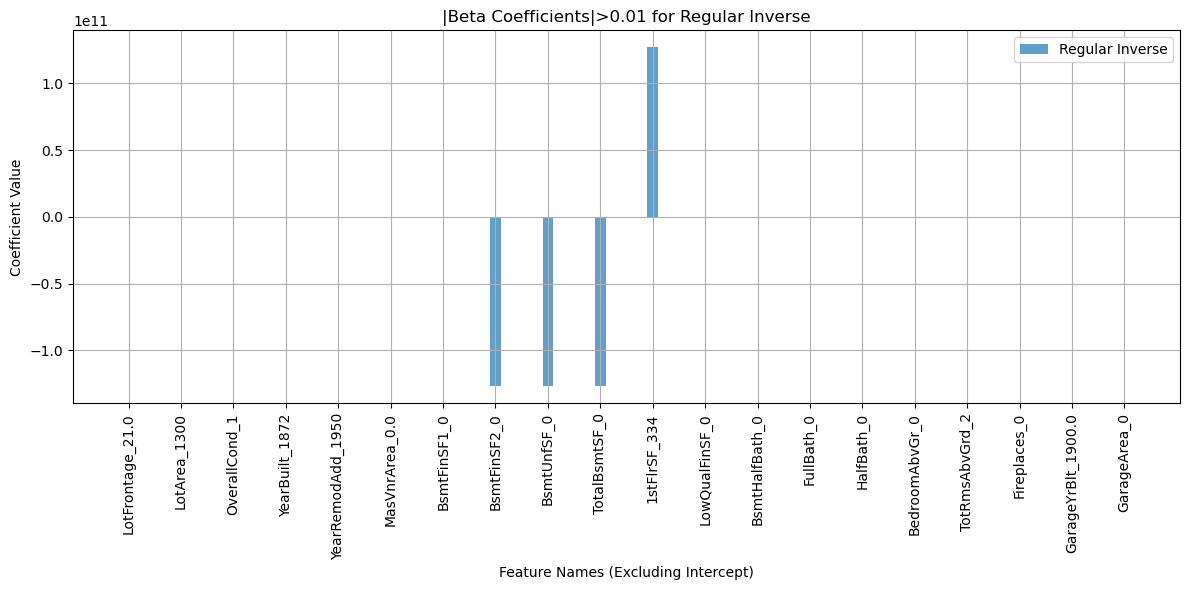

In [36]:
# Add a column of ones to X_train for the intercept term
A = np.c_[np.ones(X_train.shape[0]), X_train.values]  # Design matrix with intercept
y_train_np = y_train.values.reshape(-1, 1)

# Calculate the beta coefficients using regular inverse and pseudoinverse
beta_hat_inv = np.linalg.inv(A.T @ A) @ A.T @ y_train_np  # Regular inverse

# Exclude the intercept for the beta coefficients
beta_hat_no_intercept = beta_hat_inv[1:].flatten()

# Create a DataFrame for easier manipulation and plotting
df_betas = pd.DataFrame({
    'Regular Inverse': beta_hat_no_intercept,    
})

# Filter out rows where all beta coefficients are smaller than 0.01
df_betas_non_zero = df_betas[(df_betas.abs() >= 0.01).any(axis=1)]

# Get the feature names (excluding the intercept)
feature_names = X_train.columns  # Assuming X_train is your DataFrame of features
feature_names_no_intercept = feature_names[1:]  # Exclude the intercept term

# After filtering, use the indices of non-zero features to get their names
filtered_feature_names = feature_names_no_intercept[df_betas_non_zero.index]  # Adjust for filtered features

# Plot the beta coefficients (excluding the intercept and zero betas)
plt.figure(figsize=(12, 6))
width = 0.2  # Width of the bars
indices = np.arange(df_betas_non_zero.shape[0])  # X-axis for the features

# Plot the bars for Regular Inverse method
plt.bar(indices, df_betas_non_zero['Regular Inverse'], width=width, label='Regular Inverse', alpha=0.7)

# Use the feature names as the x-axis labels
plt.xticks(indices, filtered_feature_names, rotation=90)

# Add labels and grid
plt.title('|Beta Coefficients|>0.01 for Regular Inverse')
plt.xlabel('Feature Names (Excluding Intercept)')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.legend()

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()


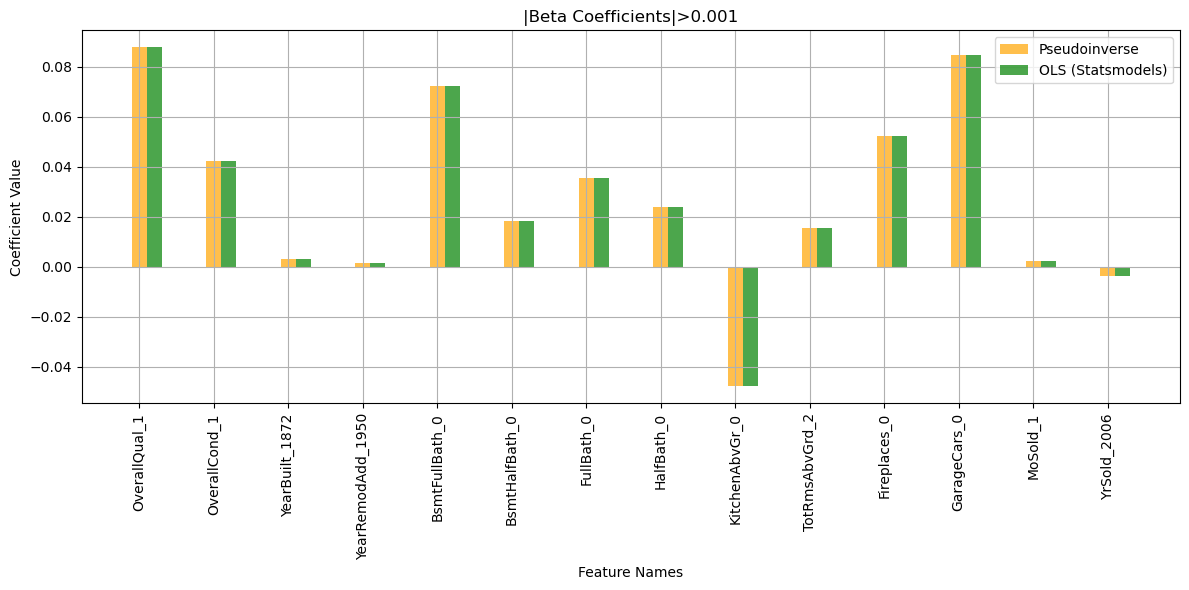

In [37]:

# Add a column of ones to X_train_unique for the intercept term
A_unique = np.c_[np.ones(X_train.shape[0]), X_train.values]  # Design matrix with intercept
y_train_np_unique = y_train.values.reshape(-1, 1)

# Calculate the beta coefficients using pseudoinverse
beta_hat_pinv_unique = np.linalg.pinv(A_unique.T @ A_unique) @ A_unique.T @ y_train_np_unique  # Pseudoinverse

# Calculate the beta coefficients using OLS from statsmodels
model_unique = sm.OLS(y_train_np_unique, A_unique)
results_unique = model_unique.fit()
beta_hat_ols_unique = results_unique.params  # OLS coefficients from statsmodels

# Exclude the intercept for both sets of beta coefficients
beta_hat_p_no_intercept_unique = beta_hat_pinv_unique[1:].flatten()
beta_hat_ols_no_intercept_unique = beta_hat_ols_unique[1:].flatten()

# Get the feature names (excluding the intercept)
feature_names_unique = X_train.columns  # Assuming X_train_unique is your DataFrame of features

df_betas_unique = pd.DataFrame({
    'Feature Names': feature_names_unique,
    'Pseudoinverse': beta_hat_p_no_intercept_unique,
    'OLS': beta_hat_ols_no_intercept_unique
})

# Filter out rows where all beta coefficients are smaller than 0.001
df_betas_non_zero_unique = df_betas_unique[(df_betas_unique[['Pseudoinverse', 'OLS']].abs() >= 0.001).any(axis=1)]

# Use the 'Feature Names' column for plotting
filtered_feature_names_unique = df_betas_non_zero_unique['Feature Names']

# Plot the beta coefficients (excluding the intercept and small betas < 0.001)
plt.figure(figsize=(12, 6))
width_unique = 0.2  # Width of the bars
indices_unique = np.arange(df_betas_non_zero_unique.shape[0])  # X-axis for the features

# Plot the bars for each method
plt.bar(indices_unique, df_betas_non_zero_unique['Pseudoinverse'], width=width_unique, label='Pseudoinverse', alpha=0.7, color='orange')
plt.bar(indices_unique + width_unique, df_betas_non_zero_unique['OLS'], width=width_unique, label='OLS (Statsmodels)', alpha=0.7, color='green')

# Use the feature names as the x-axis labels
plt.xticks(indices_unique, filtered_feature_names_unique, rotation=90)

# Add labels and grid
plt.title('|Beta Coefficients|>0.001')
plt.xlabel('Feature Names')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.legend()

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()


Coparison of Standart Error

In [38]:
# Number of observations and features
m = A.shape[0]  # Number of observations
d = A.shape[1] - 1  # Number of features (excluding the intercept)

# Predicted values for Pseudoinverse, OLS, and Regular Inverse
y_pred_pinv = A_unique @ beta_hat_pinv_unique
y_pred_ols = A_unique @ beta_hat_ols_unique
y_pred_inv = A_unique @ beta_hat_inv

# Residual sum of squares (RSS) for each method
RSS_pinv = np.sum((y_train_np - y_pred_pinv) ** 2)
RSS_ols  = np.sum((y_train_np - y_pred_ols) ** 2)
RSS_inv  = np.sum((y_train_np - y_pred_inv) ** 2)

# Variance of residuals (sigma squared) for each method
sigma_squared_pinv = RSS_pinv / (m - (d + 1))
sigma_squared_ols  = RSS_ols / (m - (d + 1))
sigma_squared_inv  = RSS_inv / (m - (d+ 1))

# Inverse of A^T A for each method
A_inv_pinv_unique = np.linalg.pinv(A_unique.T @ A_unique)
A_inv_inv_unique = np.linalg.inv(A_unique.T @ A_unique)

# Compute the standard errors for each beta coefficient
# The diagonal elements of (A^T A)^(-1) are needed
standard_errors_pinv = np.sqrt(sigma_squared_pinv * np.diag(A_inv_pinv_unique))[1:]
standard_errors_inv = np.sqrt(sigma_squared_inv * np.diag(A_inv_inv_unique))[1:]

# Use the built-in function to get OLS standard errors
standard_errors_ols = results_unique.bse[1:]  # Exclude the intercept

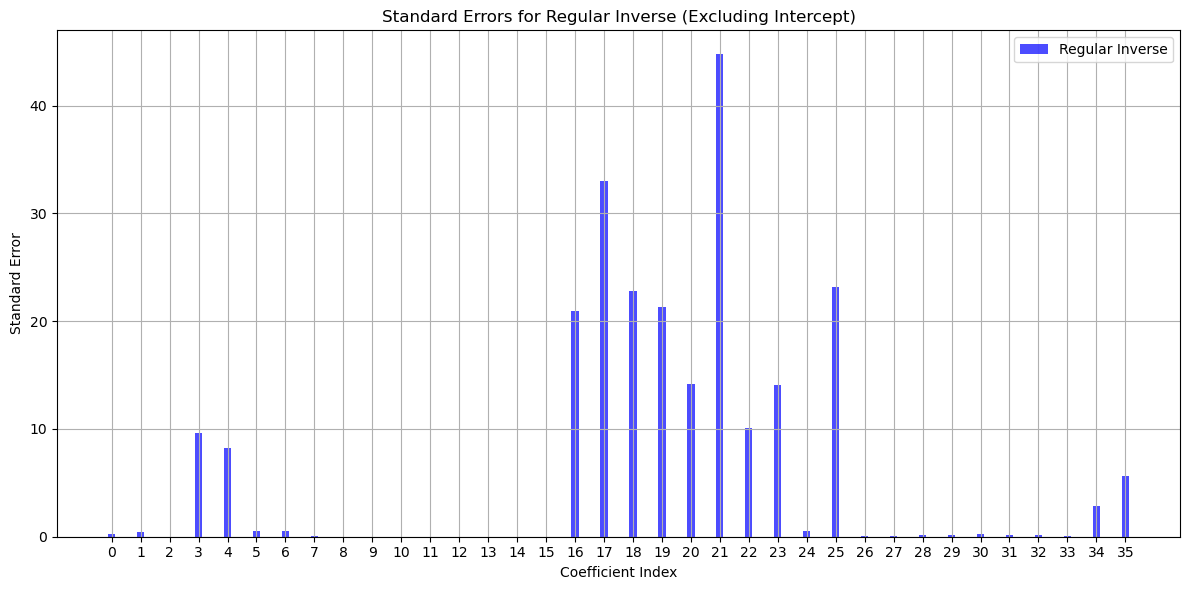

In [39]:
# Regular Inverse
width = 0.25  # Width of each bar
indices = np.arange(len(standard_errors_pinv))  # Create indices for the x-axis

plt.figure(figsize=(12, 6))

# Plot standard errors for Regular Inverse
plt.bar(indices, standard_errors_inv, width=width, label='Regular Inverse', alpha=0.7, color='blue')

# Add labels and title for Regular Inverse
plt.title('Standard Errors for Regular Inverse (Excluding Intercept)')
plt.xlabel('Coefficient Index')
plt.ylabel('Standard Error')
plt.xticks(indices)  # Set x-axis labels as the coefficient indices
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

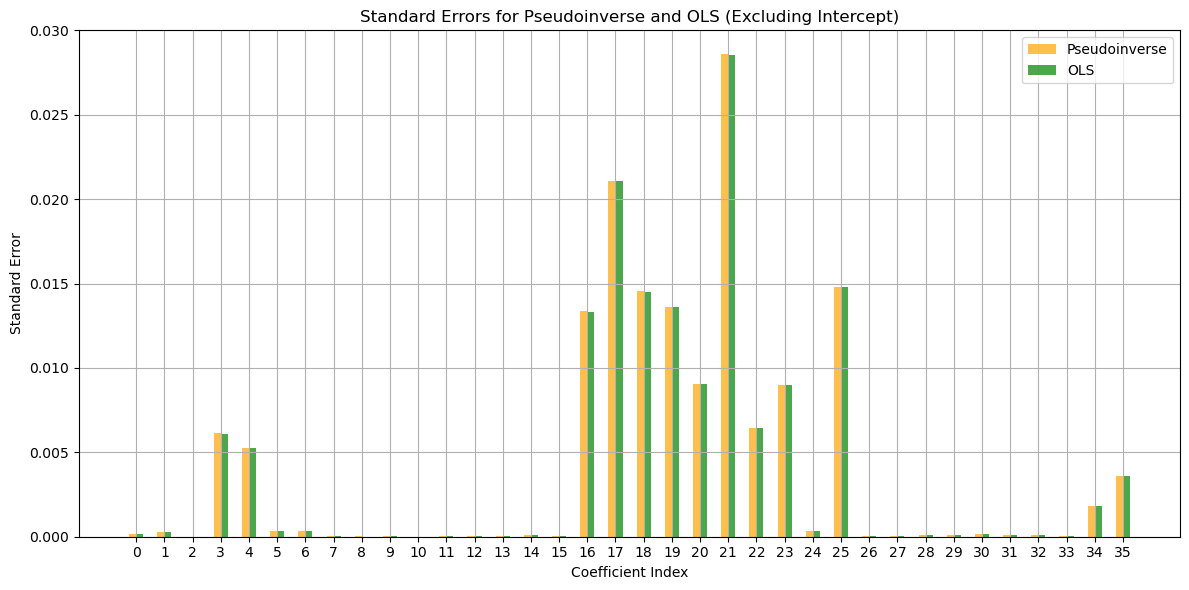

In [40]:
# Pseudoinverse and OLS
plt.figure(figsize=(12, 6))

# Plot standard errors for Pseudoinverse and OLS
plt.bar(indices - width / 2, standard_errors_pinv, width=width, label='Pseudoinverse', alpha=0.7, color='orange')
plt.bar(indices + width / 2, standard_errors_ols, width=width, label='OLS', alpha=0.7, color='green')

# Add labels and title for Pseudoinverse and OLS
plt.title('Standard Errors for Pseudoinverse and OLS (Excluding Intercept)')
plt.xlabel('Coefficient Index')
plt.ylabel('Standard Error')
plt.xticks(indices)  # Set x-axis labels as the coefficient indices
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
# Compute mean of actual values
y_mean = np.mean(y_train_np)

# Predicted values for Pseudoinverse, Regular Inverse, and OLS
y_pred_pinv = A_unique @ beta_hat_pinv_unique
y_pred_inv = A_unique @ beta_hat_inv
y_pred_ols = results_unique.predict(A_unique)  # Predicted values from OLS using statsmodels' predict method

# Compute MSE for Pseudoinverse, Regular Inverse, and OLS
MSE_pinv = np.mean((y_train_np - y_pred_pinv) ** 2)
MSE_inv = np.mean((y_train_np - y_pred_inv) ** 2)
MSE_ols = results_unique.mse_resid  # Residual MSE from statsmodels

# Compute Total Sum of Squares (TSS), shared by all models
TSS = np.sum((y_train_np - y_mean) ** 2)

# Compute Residual Sum of Squares (RSS) for Pseudoinverse and Regular Inverse
RSS_pinv = np.sum((y_train_np - y_pred_pinv) ** 2)
RSS_inv = np.sum((y_train_np - y_pred_inv) ** 2)

# Compute R^2 for Pseudoinverse, Regular Inverse, and OLS
R_squared_pinv = 1 - (RSS_pinv / TSS)
R_squared_inv = 1 - (RSS_inv / TSS)
R_squared_ols = results_unique.rsquared  # R^2 from statsmodels

# Print results for all methods

print(f"MSE Regular Inverse: {np.round(MSE_inv,3)}")
print(f"R^2 Regular Inverse: {np.round(R_squared_inv,3)}")

print(f"MSE Pseudoinverse: {np.round(MSE_pinv,3)}")
print(f"R^2 Pseudoinverse: {np.round(R_squared_pinv,3)}")

print(f"MSE OLS: {np.round(MSE_ols,3)}")
print(f"R^2 OLS: {np.round(R_squared_ols,3)}")

MSE Regular Inverse: 52178.896
R^2 Regular Inverse: -336624.772
MSE Pseudoinverse: 0.021
R^2 Pseudoinverse: 0.863
MSE OLS: 0.022
R^2 OLS: 0.863


**Conclusion**:Clearly, using the regular inverse does not work as can be seen in the Betas, the Standart Errors and the performance metrics

### D

Since polynomeal models are no longer linear, we first apply speramanns rank to see which feature show non linear relationships with the target variable

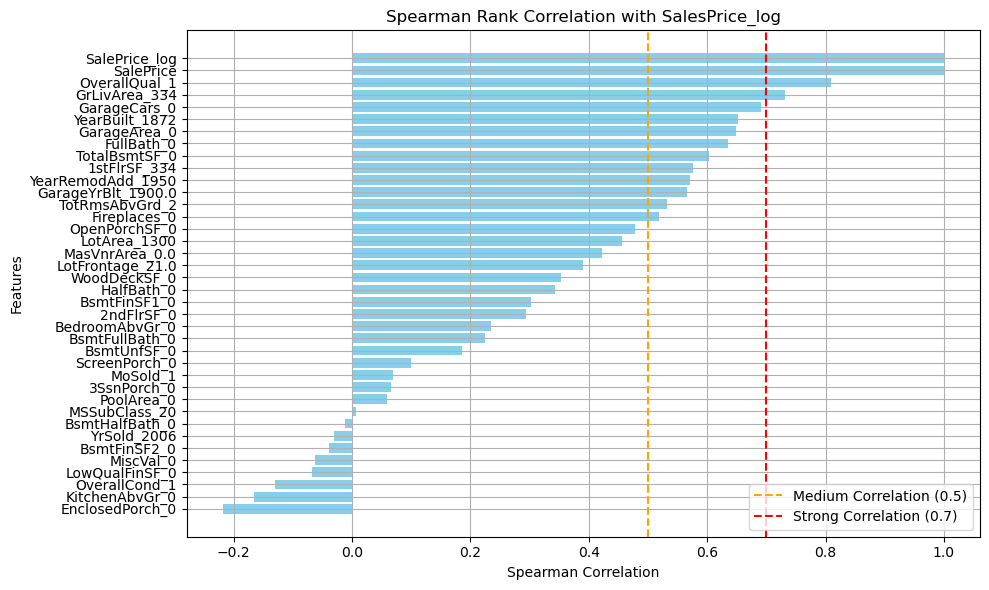

In [42]:
# Calculate Spearman's rank correlation for each feature with 'SalePrice_log'
spearman_correlations = {}
for column in housing_numerical.columns:
    corr, _ = spearmanr(housing_numerical[column], housing_numerical['SalePrice_log'])
    spearman_correlations[column] = corr

# Convert to DataFrame and sort by correlation value
spearman_df = pd.DataFrame(list(spearman_correlations.items()), columns=['Feature', 'Spearman Correlation'])
spearman_df = spearman_df.sort_values(by='Spearman Correlation', ascending=False)

# Plot the Spearman rank correlations as bars
plt.figure(figsize=(10, 6))
plt.barh(spearman_df['Feature'], spearman_df['Spearman Correlation'], color='skyblue')

# Add vertical lines for medium and strong correlation
plt.axvline(x=0.5, color='orange', linestyle='--', label='Medium Correlation (0.5)')
plt.axvline(x=0.7, color='red', linestyle='--', label='Strong Correlation (0.7)')

# Labeling the axes
plt.xlabel('Spearman Correlation')
plt.ylabel('Features')
plt.title('Spearman Rank Correlation with SalesPrice_log')
plt.gca().invert_yaxis()  # Invert y-axis to show highest correlation at the top

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()

In [43]:
# Filter features that surpass the medium threshold (|r| >= 0.5), excluding SalePrice and SalePrice_log
medium_correlation_features = spearman_df[
    (spearman_df['Spearman Correlation'].abs() >= 0.5) &
    (~spearman_df['Feature'].isin(['SalePrice', 'SalePrice_log']))
]['Feature'].tolist()

We will no apply some brut force to the selected features to find a good model:)

In [46]:
def calculate_bic(y_true, y_pred, n_params):
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)  # Residual Sum of Squares
    n = len(y_true)  # Number of observations
    bic = n * np.log(rss / n) + n_params * np.log(n)
    return bic

X = housing_numerical[medium_correlation_features]
y = housing['SalePrice_log']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize storage for results
results = []

# Get all combinations of features
features = X_train.columns
total_combinations = sum(1 for r in range(1, len(features) + 1) for _ in itertools.combinations(features, r))  # Total number of combinations

# Use tqdm to create a progress bar for all feature combinations
with tqdm(total=total_combinations, desc="Searching best model") as pbar:
    for r in range(1, len(features) + 1):
        for combination in itertools.combinations(features, r):
            # Create new feature set
            X_train_comb = X_train[list(combination)]
            X_test_comb = X_test[list(combination)]

            # Add squared terms and cross terms
            poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
            X_train_poly = poly.fit_transform(X_train_comb)
            X_test_poly = poly.transform(X_test_comb)

            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X_train_poly, y_train)
            
            # Predict on test set
            y_test_pred = model.predict(X_test_poly)

            # Calculate MSE for test
            mse_test = mean_squared_error(y_test, y_test_pred)

            # Calculate BIC for test
            bic_test = calculate_bic(y_test, y_test_pred, len(model.coef_))

            # Calculate R-squared for test
            r2_test = r2_score(y_test, y_test_pred)

            # Store the results
            results.append({
                'combination': combination,
                'mse_test': mse_test,
                'bic_test': bic_test,
                'r2_test': r2_test,
                'model': model,
                'poly': poly  # Store polynomial features for reconstruction
            })

            # Update the progress bar
            pbar.update(1)

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort by test MSE, BIC, and R-squared
best_mse_model = results_df.sort_values(by='mse_test').iloc[0]
best_bic_model = results_df.sort_values(by='bic_test').iloc[0]
best_r2_model = results_df.sort_values(by='r2_test', ascending=False).iloc[0]  # Best by R-squared

# Function to generate regression formula
def regression_formula(model, poly, feature_names):
    terms = poly.get_feature_names_out(feature_names)
    coef = model.coef_
    intercept = model.intercept_

    formula = f"{intercept:.3f}"  # Start with the intercept
    for term, coef in zip(terms, coef):
        if coef != 0:
            formula += f" + ({coef:.3f}) * {term}"
    return formula

# Return the regression formula for the best models
best_mse_formula = regression_formula(best_mse_model['model'], best_mse_model['poly'], best_mse_model['combination'])
best_bic_formula = regression_formula(best_bic_model['model'], best_bic_model['poly'], best_bic_model['combination'])
best_r2_formula = regression_formula(best_r2_model['model'], best_r2_model['poly'], best_r2_model['combination'])

# Output the formulas and test set metrics, rounding all values to 3 decimal places
print("Best Model Based on Test MSE:")
print(best_mse_formula)
print(f"Test MSE: {np.round(best_mse_model['mse_test'], 3)}, Test BIC: {np.round(best_mse_model['bic_test'], 3)}, Test R-squared: {np.round(best_mse_model['r2_test'], 3)}")

print("\nBest Model Based on Test BIC:")
print(best_bic_formula)
print(f"Test MSE: {np.round(best_bic_model['mse_test'], 3)}, Test BIC: {np.round(best_bic_model['bic_test'], 3)}, Test R-squared: {np.round(best_bic_model['r2_test'], 3)}")

print("\nBest Model Based on Test R-squared:")
print(best_r2_formula)
print(f"Test MSE: {np.round(best_r2_model['mse_test'], 3)}, Test BIC: {np.round(best_r2_model['bic_test'], 3)}, Test R-squared: {np.round(best_r2_model['r2_test'], 3)}")



Searching best model: 100%|██████████| 4095/4095 [00:44<00:00, 92.44it/s] 

Best Model Based on Test MSE:
10.439 + (0.052) * OverallQual_1 + (0.000) * GrLivArea_334 + (0.006) * YearBuilt_1872 + (0.000) * GarageArea_0 + (0.000) * TotalBsmtSF_0 + (0.000) * YearRemodAdd_1950 + (0.042) * Fireplaces_0 + (0.003) * OverallQual_1^2 + (0.000) * OverallQual_1 GrLivArea_334 + (-0.000) * OverallQual_1 YearBuilt_1872 + (0.000) * OverallQual_1 GarageArea_0 + (0.000) * OverallQual_1 TotalBsmtSF_0 + (-0.001) * OverallQual_1 YearRemodAdd_1950 + (-0.005) * OverallQual_1 Fireplaces_0 + (-0.000) * GrLivArea_334^2 + (0.000) * GrLivArea_334 YearBuilt_1872 + (-0.000) * GrLivArea_334 GarageArea_0 + (-0.000) * GrLivArea_334 TotalBsmtSF_0 + (0.000) * GrLivArea_334 YearRemodAdd_1950 + (0.000) * GrLivArea_334 Fireplaces_0 + (-0.000) * YearBuilt_1872^2 + (0.000) * YearBuilt_1872 GarageArea_0 + (0.000) * YearBuilt_1872 TotalBsmtSF_0 + (-0.000) * YearBuilt_1872 YearRemodAdd_1950 + (-0.001) * YearBuilt_1872 Fireplaces_0 + (-0.000) * GarageArea_0^2 + (-0.000) * GarageArea_0 TotalBsmtSF_0 + (-

Conclusion: Addin interaction and higher degree terms does ** not really increase performance**.
This makes, since the underlying relationships are excpected to be linear 

## Task Nr.3

### A

In [355]:
# X_encoded: All features from housing_encoded except SalePrice and SalePrice_log
# y_encoded: Target variable (log-transformed SalePrice)
X_encoded = housing_encoded.drop(columns=['SalePrice', 'SalePrice_log'])
y_encoded = housing_encoded['SalePrice_log']

# Split the dataset into 70% train and 30% test for housing_encoded
X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)


In [356]:
# Train a Linear Regression model on housing_encoded data
lin_reg_encoded = LinearRegression()
lin_reg_encoded.fit(X_encoded_train, y_encoded_train)

# Predict on both the training and test sets for housing_encoded
y_encoded_train_pred = lin_reg_encoded.predict(X_encoded_train)
y_encoded_test_pred = lin_reg_encoded.predict(X_encoded_test)

# Evaluate the model using Mean Squared Error (MSE) and R² for housing_encoded
train_mse_encoded = mean_squared_error(y_encoded_train, y_encoded_train_pred)
test_mse_encoded = mean_squared_error(y_encoded_test, y_encoded_test_pred)

train_r2_encoded = r2_score(y_encoded_train, y_encoded_train_pred)
test_r2_encoded = r2_score(y_encoded_test, y_encoded_test_pred)

# Print the results for the encoded dataset
print(f"Training MSE (encoded): {np.round(train_mse_encoded, 3)}")
print(f"Test MSE (encoded): {np.round(test_mse_encoded, 3)}")
print(f"Training R² (encoded): {np.round(train_r2_encoded, 3)}")
print(f"Test R² (encoded): {np.round(test_r2_encoded, 3)}")


Training MSE (encoded): 0.008
Test MSE (encoded): 0.028
Training R² (encoded): 0.948
Test R² (encoded): 0.836


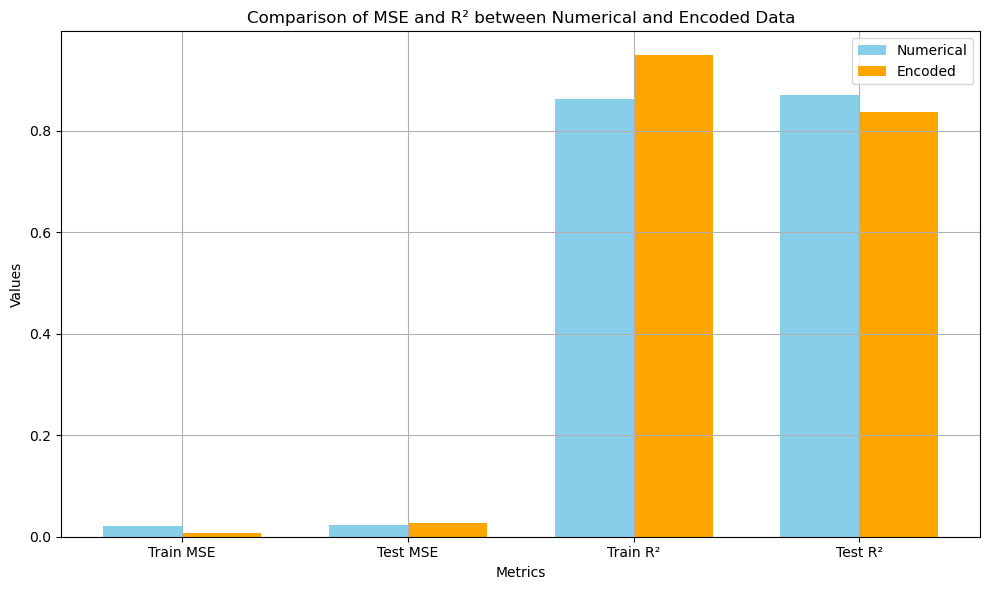

In [357]:
# Data for the bar plot
labels = ['Train MSE', 'Test MSE', 'Train R²', 'Test R²']

# Numerical results
numerical_results = [
    train_mse, test_mse, train_r2, test_r2  # These are from the original numerical data
]

# Encoded results
encoded_results = [
    train_mse_encoded, test_mse_encoded, train_r2_encoded, test_r2_encoded  # From the encoded data
]

# X-axis positions for the bars
x = np.arange(len(labels))

# Width of the bars
width = 0.35

# Create the bar plot
plt.figure(figsize=(10, 6))

# Bars for numerical results
plt.bar(x - width/2, numerical_results, width=width, label='Numerical', color='skyblue')

# Bars for encoded results
plt.bar(x + width/2, encoded_results, width=width, label='Encoded', color='orange')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of MSE and R² between Numerical and Encoded Data')
plt.xticks(x, labels)  # Set the x-ticks to the label names
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()

The plot above shows that the **MSE is lower and the R-squared is higher on the test set for the full data set**. However the opposit
is true for the test set. This is indicative of **overfitting in the case of the full data set**

### B

In [359]:
####################################################
# --- Truncated Pseudoinverse using TruncatedSVD ---
####################################################

# Applying TruncatedSVD (acting as a truncation on pseudoinverse)
svd = TruncatedSVD(n_components=min(X_encoded_train.shape) - 1)  # Keep as many components as features - 1
X_encoded_train_svd = svd.fit_transform(X_encoded_train)
X_encoded_test_svd = svd.transform(X_encoded_test)

# Fit a linear regression on truncated pseudoinverse
lin_reg_svd = LinearRegression()
lin_reg_svd.fit(X_encoded_train_svd, y_encoded_train)

# Predict on both train and test sets
y_train_pred_svd = lin_reg_svd.predict(X_encoded_train_svd)
y_test_pred_svd = lin_reg_svd.predict(X_encoded_test_svd)

# Compute in-sample and out-of-sample MSE for truncated pseudoinverse
mse_train_svd = mean_squared_error(y_encoded_train, y_train_pred_svd)
mse_test_svd = mean_squared_error(y_encoded_test, y_test_pred_svd)

################################################
# --- Ridge Regression with Cross-Validation ---
################################################

ridge = Ridge()

# Set up the parameter grid for Ridge regression
ridge_params = {'alpha': np.logspace(-4, 4, 50)}  # Try a wide range of alpha values

# 8-fold cross-validation for Ridge regression
ridge_cv = GridSearchCV(ridge, ridge_params, cv=8, scoring='neg_mean_squared_error')
ridge_cv.fit(X_encoded_train, y_encoded_train)

# Best Ridge model
best_ridge = ridge_cv.best_estimator_

# Predict on both train and test sets for Ridge
y_train_pred_ridge = best_ridge.predict(X_encoded_train)
y_test_pred_ridge = best_ridge.predict(X_encoded_test)

# Compute in-sample and out-of-sample MSE for Ridge regression
mse_train_ridge = mean_squared_error(y_encoded_train, y_train_pred_ridge)
mse_test_ridge = mean_squared_error(y_encoded_test, y_test_pred_ridge)

################################################
# --- Lasso Regression with Cross-Validation ---
################################################

lasso = Lasso(max_iter=10000)

# Set up the parameter grid for Lasso regression
lasso_params = {'alpha': np.logspace(-4, 4, 50)}  # Try a wide range of alpha values

# 8-fold cross-validation for Lasso regression
lasso_cv = GridSearchCV(lasso, lasso_params, cv=8, scoring='neg_mean_squared_error')
lasso_cv.fit(X_encoded_train, y_encoded_train)

# Best Lasso model
best_lasso = lasso_cv.best_estimator_

# Predict on both train and test sets for Lasso
y_train_pred_lasso = best_lasso.predict(X_encoded_train)
y_test_pred_lasso = best_lasso.predict(X_encoded_test)

# Compute in-sample and out-of-sample MSE for Lasso regression
mse_train_lasso = mean_squared_error(y_encoded_train, y_train_pred_lasso)
mse_test_lasso = mean_squared_error(y_encoded_test, y_test_pred_lasso)

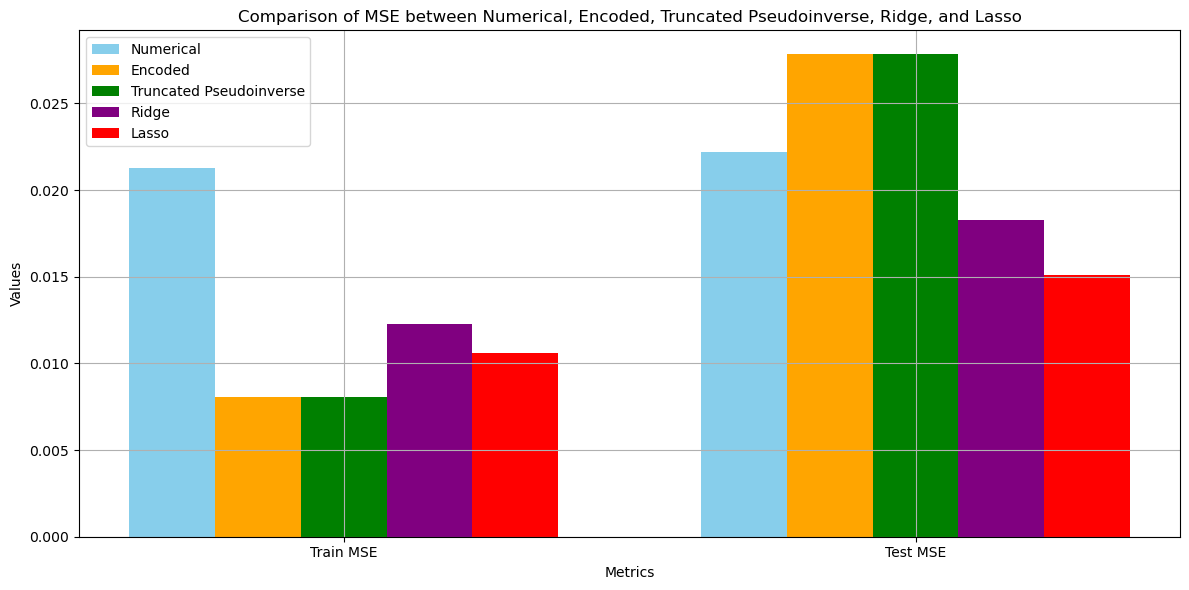

In [360]:
# Data for the bar plot
labels = ['Train MSE', 'Test MSE']

# Numerical results
numerical_results = [train_mse, test_mse]  # These are from the original numerical data

# Encoded results
encoded_results = [train_mse_encoded, test_mse_encoded]  # From the encoded data

# Truncated Pseudoinverse results
svd_results = [mse_train_svd, mse_test_svd]

# Ridge results
ridge_results = [mse_train_ridge, mse_test_ridge]

# Lasso results
lasso_results = [mse_train_lasso, mse_test_lasso]

# X-axis positions for the bars
x = np.arange(len(labels))

# Width of the bars
width = 0.15

# Create the bar plot
plt.figure(figsize=(12, 6))

# Bars for numerical results
plt.bar(x - 2*width, numerical_results, width=width, label='Numerical', color='skyblue')

# Bars for encoded results
plt.bar(x - width, encoded_results, width=width, label='Encoded', color='orange')

# Bars for Truncated Pseudoinverse results
plt.bar(x, svd_results, width=width, label='Truncated Pseudoinverse', color='green')

# Bars for Ridge results
plt.bar(x + width, ridge_results, width=width, label='Ridge', color='purple')

# Bars for Lasso results
plt.bar(x + 2*width, lasso_results, width=width, label='Lasso', color='red')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of MSE between Numerical, Encoded, Truncated Pseudoinverse, Ridge, and Lasso')
plt.xticks(x, labels)  # Set the x-ticks to the label names
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()

Truncating the Pseudoinverse did not bring an increase in performance. The best model is the Lasso Regression

### C

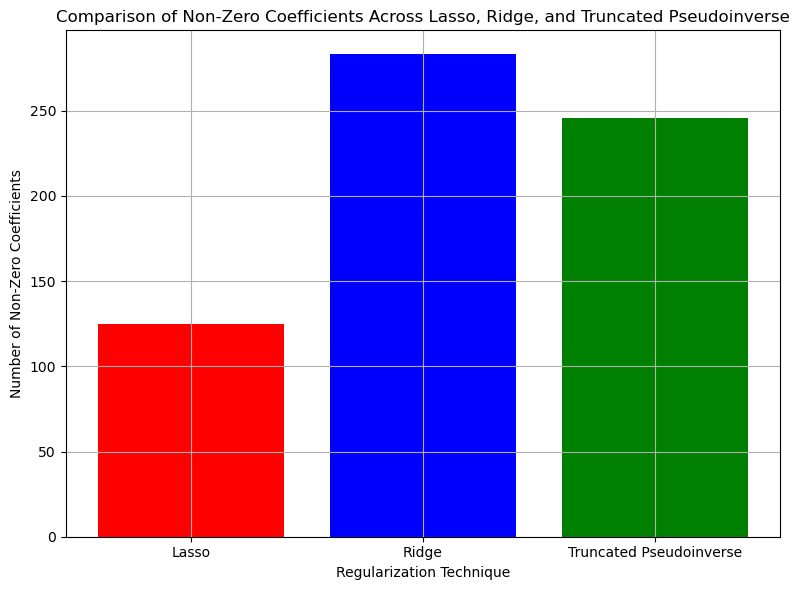

In [365]:
# --- Count non-zero coefficients for Lasso ---
lasso_non_zero_count = np.sum(best_lasso.coef_ != 0)

# --- Count non-zero coefficients for Ridge ---
ridge_non_zero_count = np.sum(best_ridge.coef_ != 0)  # Should be equal to the number of features since Ridge doesn't zero out coefficients

# Count non-zero singular values from the truncated SVD
svd_non_zero_count = np.sum(svd.singular_values_ > 1e-10)  # Consider singular values greater than a small threshold

# Labels for the plot
labels = ['Lasso', 'Ridge', 'Truncated Pseudoinverse']

# Values for the plot
non_zero_counts = [lasso_non_zero_count, ridge_non_zero_count, svd_non_zero_count]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(labels, non_zero_counts, color=['red', 'blue', 'green'])

# Add labels and title
plt.xlabel('Regularization Technique')
plt.ylabel('Number of Non-Zero Coefficients')
plt.title('Comparison of Non-Zero Coefficients Across Lasso, Ridge, and Truncated Pseudoinverse')

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()

### Interpretation:

- **Lasso (~110 non-zero coefficients)**: 
   - Uses **L1 regularization**, which forces many coefficients to exactly zero, performing **feature selection** by retaining only the most important features.

- **Ridge (~260 non-zero coefficients)**:
   - Uses **L2 regularization**, which shrinks the coefficients but keeps all of them non-zero. It **retains all features**, but reduces their magnitude.

- **Truncated Pseudoinverse (~230 non-zero coefficients)**:
   - Performs **dimensionality reduction**, retaining most coefficients but removing those associated with smaller singular values, reducing the model complexity without full feature elimination.

### D 

Based on the MSE I would opt for the Lasso Regression. Further, I would implement Normalization of the data beyond what we did to reduce the size in the features. 